In [29]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DecoderMLP, RecurrentNetwork
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import yfinance as yf
import itertools

In [2]:
def load_data():
    id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
    ticker_to_name_path = "Datasets/kaggle/Company.csv"

    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)
    tickers = company_name_df.ticker_symbol.tolist()

    market_data = yf.download((' ').join(tickers), start="2015-01-01", end="2020-01-01", group_by = 'ticker')

    returns = pd.DataFrame()
    
    # for ticker in market_data.columns.levels[0]:
    #     returns[ticker] = market_data[ticker].Close.pct_change(1).dropna()

    for ticker in market_data.columns.levels[0]:
        returns[ticker] = market_data[ticker].Close.shift(-1).dropna()

    market_data = market_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    # market_data['Returns'] = None
    # market_data['Returns'][:-6] = returns.values.flatten()

    # market_data['Close_next'] = None
    # market_data['Close_next'][:-6] = returns.values.flatten()

    # market_data = market_data.fillna(market_data.Returns.mean())
    market_data = market_data.dropna()
    market_data = market_data.reset_index()

    market_data.to_csv('Datasets/market/market.csv', index=False)

    return market_data

In [3]:
data = load_data()
for i, j in itertools.product(range(0, 7548, 6), range(6)):
    data.loc[i+j, 'time_idx'] = i and int(i / 6) or 0

data.time_idx = data.time_idx.astype('int')

[*********************100%***********************]  6 of 6 completed


In [4]:
data[data.Ticker == 'TSLA']

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,time_idx
5,2015-01-02,TSLA,14.620667,14.620667,14.883333,14.217333,14.858000,71466000,0
11,2015-01-05,TSLA,14.006000,14.006000,14.433333,13.810667,14.303333,80527500,1
17,2015-01-06,TSLA,14.085333,14.085333,14.280000,13.614000,14.004000,93928500,2
23,2015-01-07,TSLA,14.063333,14.063333,14.318667,13.985333,14.223333,44526000,3
29,2015-01-08,TSLA,14.041333,14.041333,14.253333,14.000667,14.187333,51637500,4
...,...,...,...,...,...,...,...,...,...
7523,2019-12-24,TSLA,28.350000,28.350000,28.364668,27.512667,27.890667,120820500,1253
7529,2019-12-26,TSLA,28.729334,28.729334,28.898666,28.423332,28.527332,159508500,1254
7535,2019-12-27,TSLA,28.691999,28.691999,29.020666,28.407333,29.000000,149185500,1255
7541,2019-12-30,TSLA,27.646667,27.646667,28.600000,27.284000,28.586000,188796000,1256


In [8]:
train_cutoff = 1157

In [9]:
train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= train_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=['Ticker'],
    max_encoder_length=14,
    max_prediction_length=7,
    static_categoricals=['Ticker'],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'],
    # time_varying_unknown_reals=['Close'],
    target_normalizer=GroupNormalizer(groups=["Ticker"]),
    )

In [12]:
validation = TimeSeriesDataSet.from_dataset(train, data, min_prediction_idx=train.index.time.max() + 1, stop_randomization=True)

In [14]:
batch_size = 256
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [15]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


1.301350712776184

In [16]:
pl.seed_everything(1)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    train,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 1
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\loops\utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 19.2k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval T

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at b:\HSE_Masters\.lr_find_5e8ae559-414a-450d-8c7d-de5629a82330.ckpt


suggested learning rate: 0.04365158322401657


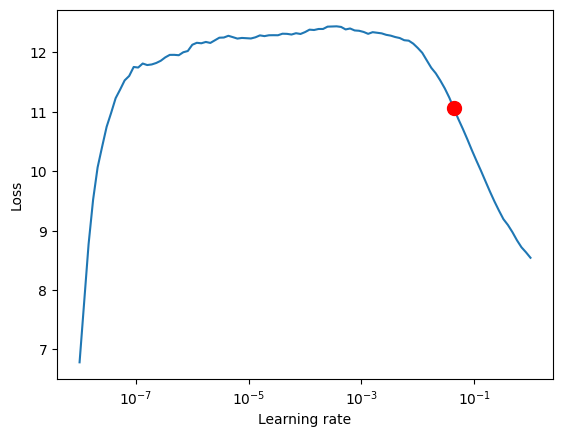

C:\Users\Andrei\AppData\Local\Temp\ipykernel_9016\2840967511.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [17]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-8,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [18]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # limit_train_batches=40,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    train,
    learning_rate=0.1,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=30,
    reduce_on_plateau_patience=5,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 62.7k


In [19]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 24    
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 96    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 896   
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [21]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(3.3430)

In [24]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

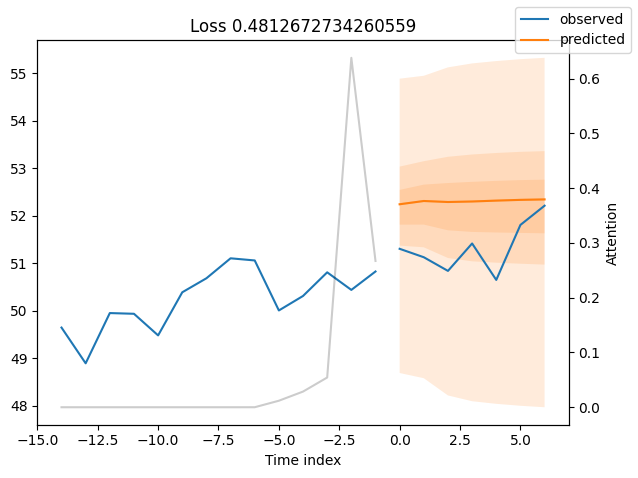

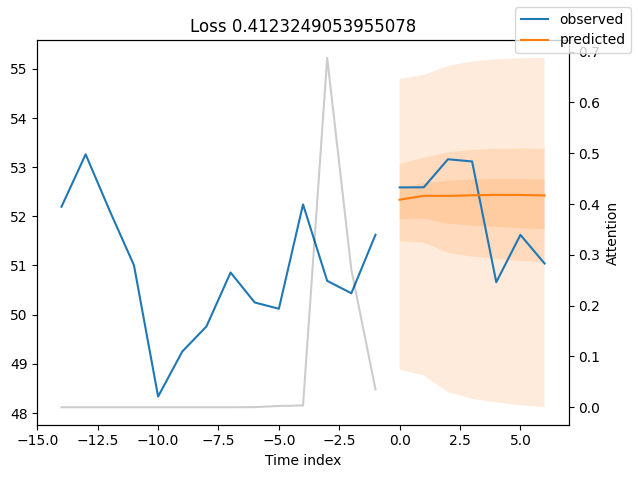

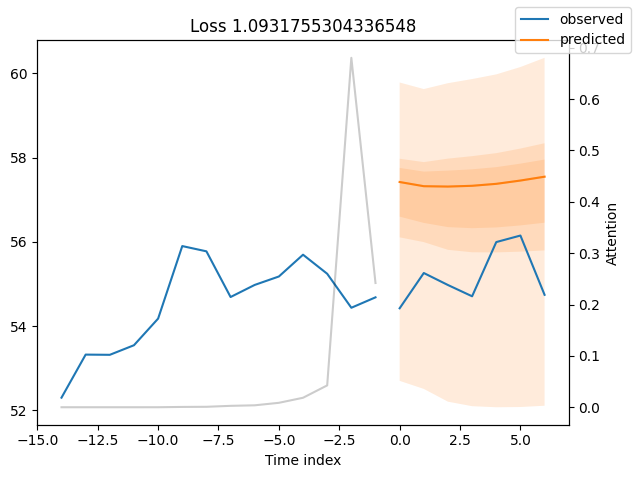

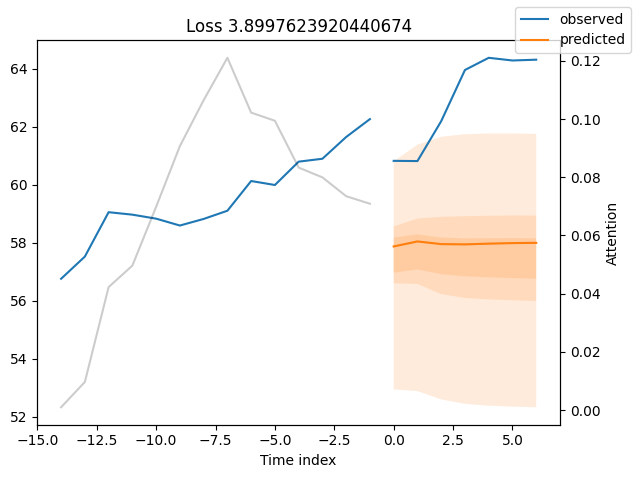

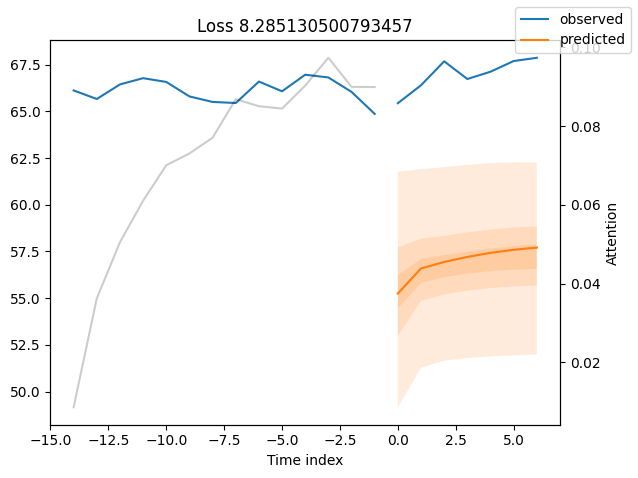

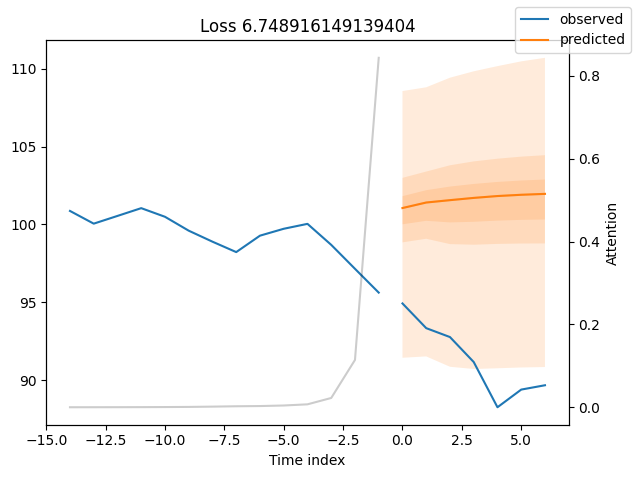

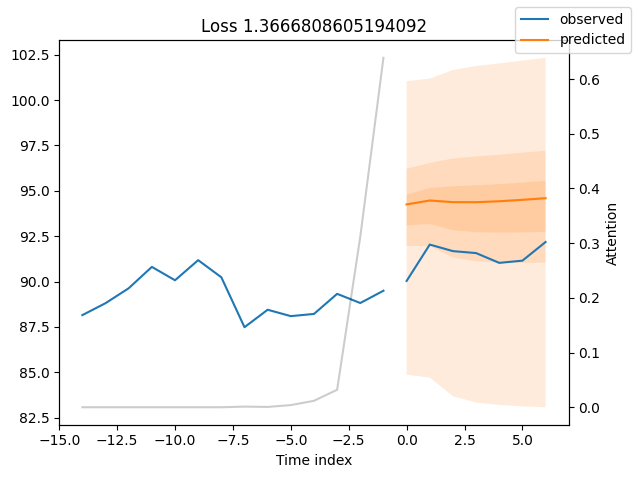

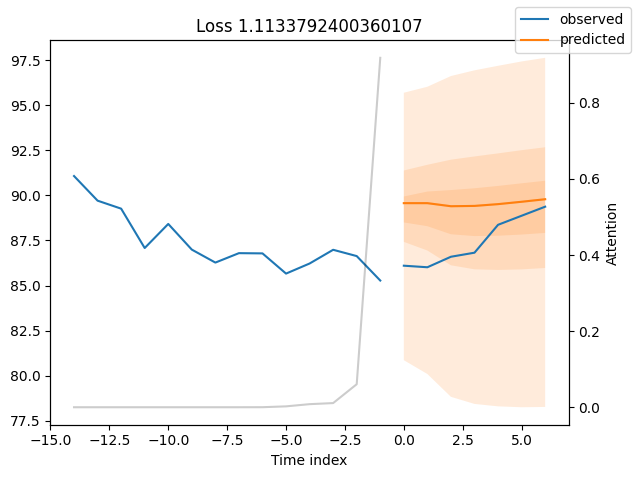

In [25]:
for idx in range(1, 200, 25):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

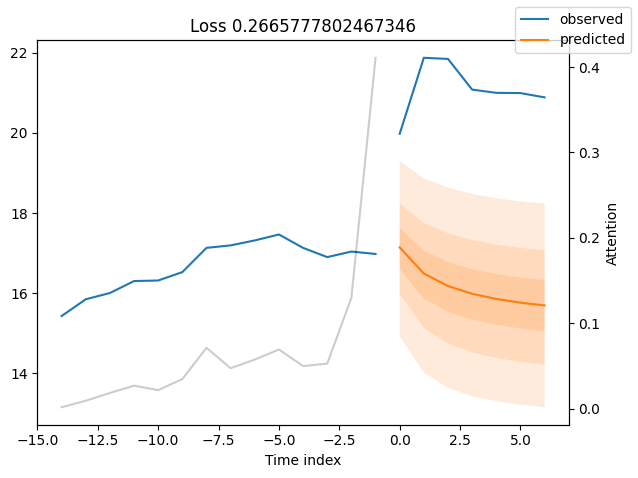

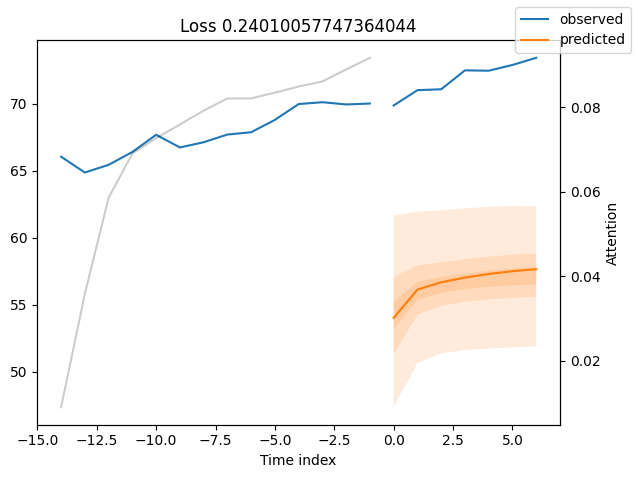

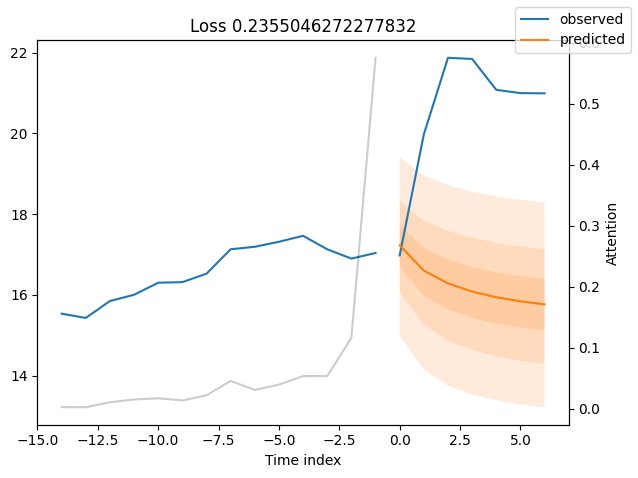

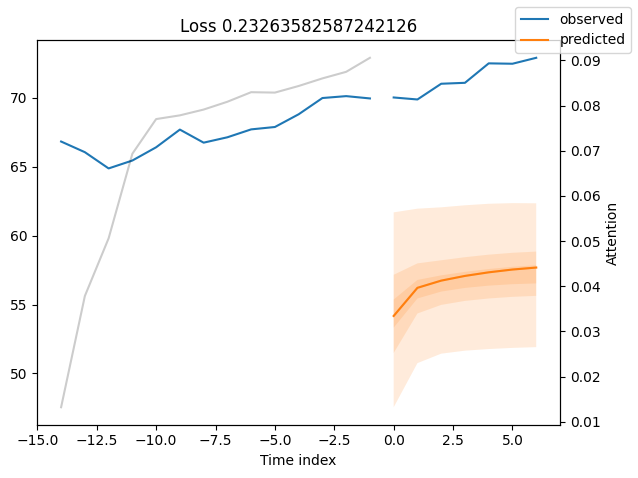

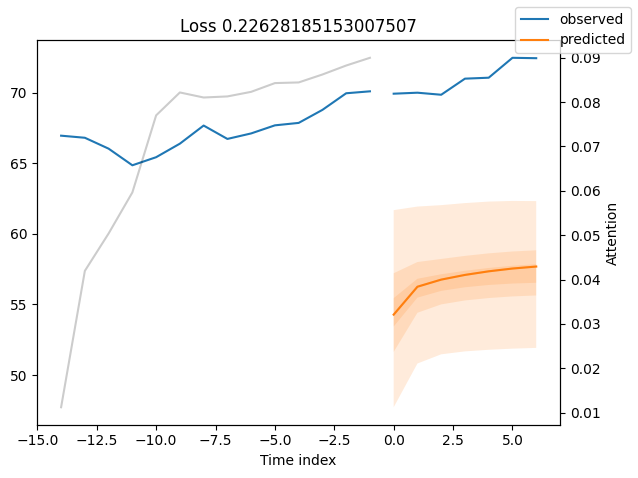

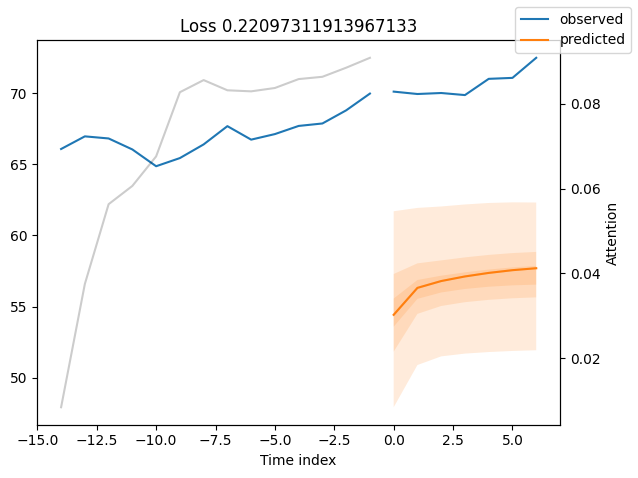

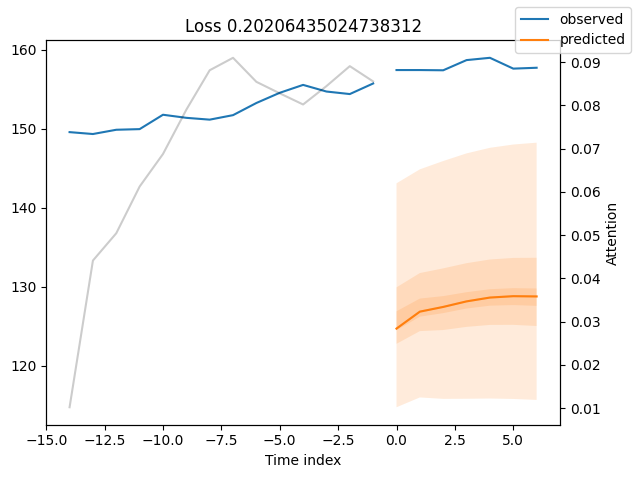

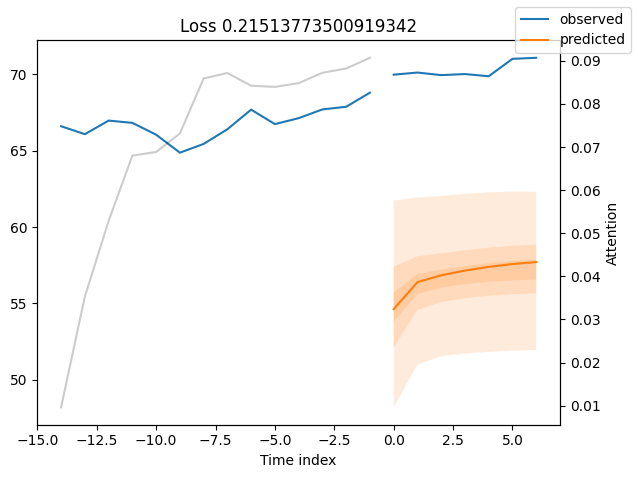

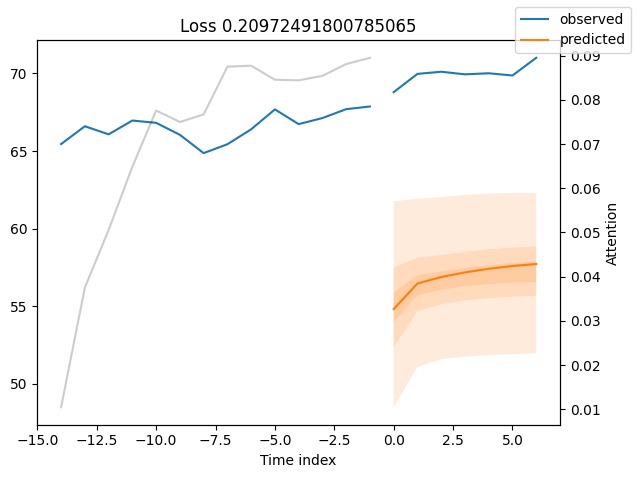

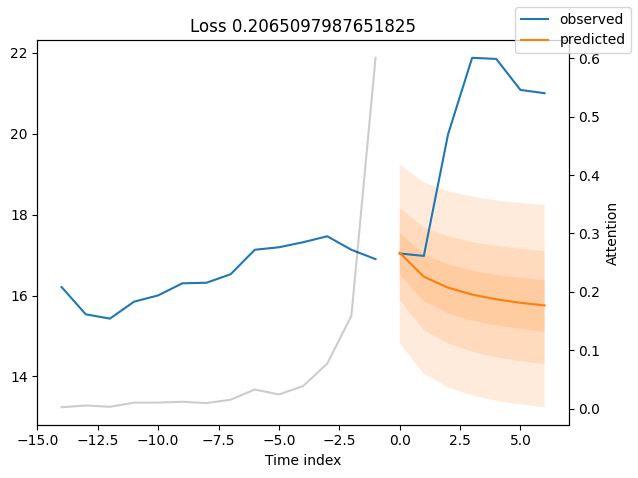

In [26]:
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    train.filter(lambda x: (x.Ticker == "AAPL") & (x.time_idx_first_prediction == 20)),
    mode="quantiles",
)

In [ ]:
raw_prediction, x = best_tft.predict(
    train.filter(lambda x: (x.Ticker == "TSLA") & (x.time_idx_first_prediction == 20)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
train[3001]